In [20]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import numpy as np
import math

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import cross_val_score

from collections import defaultdict
import cPickle

import csv

### Data Processing

#### Prelim Vars (Edit when running)

**Preconditions**:

State format: 2 letters, both caps (ie 'NY')

Candidate format: Last name, capital letter

Zip file name format: ../CSVs/[state]zips.csv

Contribution file name format: ../CSVs/[candidate]-[state].csv

Expenditure file name format: ../CSVs/[candidate]-Expenditures.csv

In [21]:
state = 'NY'
candidate = 'Clinton'

#### The full function

In [80]:
# Return dictionary of zip codes to counties
def getZips(state):
    zipToCounty = defaultdict(int)

    with open('../CSVs/' + state + 'zips.csv', 'rb') as f:
        reader = csv.reader(f)
        for row in reader:
            zipToCounty[row[0]] = row[1]
    return zipToCounty

# Return dataframe of contributions for a candidate in a state
def getContributions(state, candidate):
    # Build new dataframe, sort by date, and add cumulative column
    df = pd.read_csv('../CSVs/' + candidate + '-' + state + '.csv')
    df2 = pd.DataFrame({'date' : df.contb_receipt_amt, 'amt' : df.contbr_occupation, 'zip9' : df.contbr_st})
    df3 = df2.sort(['date'])
    df3['cum_amt'] = df3.amt.cumsum()
    return df3

def getExpenditures(state, candidate):
    df = pd.read_csv('../CSVs/' + candidate + '-Expenditures.csv')
    df = df[df['recipient_city'] == state]
    df2 = pd.DataFrame({'date' : df.disb_amt, 'amt' : df.recipient_nm, 'zip9' : df.recipient_st})
    df3 = df2.sort(['date'])
    df3['cum_amt'] = df3.amt.cumsum()
    return df3

# Clean up the dataframe
def parseFinances(df):
    # Index the dates numerically
    df_len = len(df.index)
    bucket_size = int(df_len/1000)
    idx_date = []
    idx = 0
    curr_date = df.date[0]
    for i in df.date:
        if i != curr_date:
            curr_date = i
            idx += 1
        idx_date.append(idx)
    df['idx_date'] = idx_date

    # Transform zip data to county data
    zipToCounty = getZips(state)
    zip6 = []
    county = []    
    for i in df.zip9:
        if not math.isnan(float(i)):
            z = str(int(i))
            if len(str(int(i))) > 5:
                z = z[:5]
            zip6.append(z)
            while not zipToCounty[z]:
                intZ = int(z)
                intZ -= 1
                z = str(intZ)
                if intZ < 10000:
                    zipToCounty[z] = "None"
            county.append(zipToCounty[z])
        else:
            zip6.append("00000")
            county.append("None")
    df['zip6'] = zip6
    df['county'] = county
    return df

# Features are [avg contribution, total raised, total contributions, {those 3 for the last 14 days}]
def addContributionsToFF(state, candidate, FF, counties, inclTime=True, timeRange=14):
    candidateFinances = parseFinances(getContributions(state, candidate))
    candidateByCounty = candidateFinances.groupby('county')
    countyAggregates = candidateByCounty['amt'].agg(['mean', 'sum', 'count'])
    numCounties = len(counties)
    
    for i in range(numCounties):
        FF[i] += [countyAggregates['mean'][i], countyAggregates['sum'][i], countyAggregates['count'][i]]
            
    if inclTime:
        candidateByDate = candidateFinances.groupby('idx_date')
        endDate = list(candidateByDate.groups)[-1]
        startDate = endDate - timeRange
        for i in range(startDate, endDate):
            cbdByCounty = candidateByDate.get_group(i).groupby('county')
            timeAggregates = cbdByCounty['amt'].agg(['mean', 'sum', 'count'])
            for j in range(numCounties):
                if counties[j] in timeAggregates.index:
                    FF[j] += [timeAggregates['mean'][counties[j]], timeAggregates['sum'][counties[j]], timeAggregates['count'][counties[j]]]
                else:
                    FF[j] += [0, 0, 0]

# Features are [avg contribution, total raised, total contributions, {those 3 for the last 14 days}]
def addExpendituresToFF(state, candidate, FF, counties, inclTime=True, timeRange=14):
    candidateFinances = parseFinances(getExpenditures(state, candidate))
    candidateByCounty = candidateFinances.groupby('county')
    countyAggregates = candidateByCounty['amt'].agg(['mean', 'sum', 'count'])
    numCounties = len(counties)
    
    for j in range(numCounties):
        if counties[j] in countyAggregates.index:
            FF[j] += [countyAggregates['mean'][counties[j]], countyAggregates['sum'][counties[j]], countyAggregates['count'][counties[j]]]
        else:
            FF[j] += [0, 0, 0]
            
    if inclTime:
        candidateByDate = candidateFinances.groupby('idx_date')
        endDate = list(candidateByDate.groups)[-1]
        startDate = endDate - timeRange
        for i in range(startDate, endDate):
            cbdByCounty = candidateByDate.get_group(i).groupby('county')
            timeAggregates = cbdByCounty['amt'].agg(['mean', 'sum', 'count'])
            for j in range(numCounties):
                if counties[j] in timeAggregates.index:
                    FF[j] += [timeAggregates['mean'][counties[j]], timeAggregates['sum'][counties[j]], timeAggregates['count'][counties[j]]]
                else:
                    FF[j] += [0, 0, 0]
    
# Takes state and list of candidates and builds featureFrame
def buildFinanceFeatureFrame(state, candidates, X=[], inclTime=True, timeRange=14):
    tempFinances = parseFinances(getContributions(state, candidates[0]))
    counties = [tup[0] for tup in list(tempFinances.groupby('county'))]
    numCounties = len(counties)
    if not X:
        X = [[] for i in range(numCounties)]
    
    for candidate in candidates:
        addContributionsToFF(state, candidate, X, counties, inclTime=inclTime, timeRange=timeRange)
#         addExpendituresToFF(state, candidate, X, counties, inclTime=inclTime, timeRange=timeRange)
    
    if "None" in counties:
        X.pop(counties.index("None"))
    return X

In [63]:
def buildTwitterFeatureFrame(state, candidates, X=[]):
    with open('../pickles/' + state + '_feature_df.p', 'rb') as f:
        twitterData = cPickle.load(f)

    colns = list(twitterData.columns.values)
    ids = []
    for c in candidates:
        ids += [i for i, coln in enumerate(colns) if c in coln]

    if not X:
        X = [[] for i in range(len(twitterData))]
    iterIdx= 0
    for index, row in twitterData.iterrows():
        X[iterIdx] += list(row[ids].values)
        iterIdx += 1
    return X

In [75]:
def buildSmallPollFF(numCounties, X=[]):
    if not X:
        X = [[] for i in range(numCounties)]
    tbl = []
    with open('../CSVs/NyPrimaryPollsD.csv', 'rb') as f:
        reader = csv.reader(f)
        for row in reader:
            # Remove LVs
            if row[1]:
                row[1] = row[1][:-3]
            tbl.append(row)
    X1 = map(float, tbl[1][3:])
    X1 = [X[i] += X1 for i in range(numCounties)]
    return X1

def buildBigPollFF(numCounties, X=[]):
    tbl = []
    with open('../CSVs/NyPrimaryPollsD.csv', 'rb') as f:
        reader = csv.reader(f)
        for row in reader:
            # Remove LVs
            if row[1]:
                row[1] = row[1][:-3]
            tbl.append(row)
    X2 = [map(float, t[1:]) for t in tbl[3:]]
    X2 = [i for arr in X2 for i in arr]
    X2 = [X2 for i in range(numCounties)]
    return X2

In [64]:
def buildTargetDems(state):
    y = []
    with open('../CSVs/' + state + 'PrimaryResultsRaw.csv', 'rb') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if not i:
                continue
            percent = float(row[1].replace(',', ''))/(int(row[1].replace(',', '')) + int(row[2].replace(',', '')))
            y.append(percent)
    return y

def buildTargetReps(state):
    y = []
    with open('../CSVs/' + state + 'PrimaryResultsRaw.csv', 'rb') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if not i:
                continue
            percent1 = float(row[3].replace(',', ''))/(int(row[3].replace(',', '')) + \
                                                       int(row[4].replace(',', '')) + \
                                                       int(row[5].replace(',', '')))
            percent2 = float(row[4].replace(',', ''))/(int(row[3].replace(',', '')) + \
                                                       int(row[4].replace(',', '')) + \
                                                       int(row[5].replace(',', '')))
            y.append([percent1, percent2])
    return y

In [76]:
# X = buildFinanceFeatureFrame('NY', ['Clinton', 'Sanders'], inclTime=True)
# X = buildTwitterFeatureFrame('NY', ['Clinton', 'Sanders'], X = X)
X = buildSmallPollFF()
# X = buildBigPollFF()
y = buildTarget('NY')

NameError: global name 'numCounties' is not defined

In [71]:
def testRandomForest(X, y):
    rng = np.random.RandomState(0)

    # dataset = load_boston()
    # X_full, y_full = dataset.data, dataset.target
    X_full = np.array(X)
    y_full = np.array(y)
    n_samples = X_full.shape[0]
    n_features = X_full.shape[1]

    # Estimate the score on the entire dataset, with no missing values
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    score = cross_val_score(estimator, X_full, y_full).mean()
    print("Score with the entire dataset = %.2f" % score)
    return estimator

In [73]:
estimator = testRandomForest(X, y)

Score with the entire dataset = -0.49


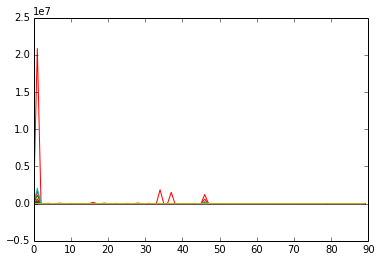

In [81]:
df = buildFinanceFeatureFrame('NY', ['Clinton', 'Sanders'], inclTime=True)
for row in df:
    plt.plot(row)
plt.show()

## Below is old scratchwork that has been reformatted nicely above

#### Finance Data

In [5]:
zipToCounty = defaultdict(int)

with open('../CSVs/NYzips.csv', 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        zipToCounty[row[0]] = row[1]

#### Clinton

In [7]:
df = pd.read_csv('../CSVs/Clinton-NY.csv')
df2 = pd.DataFrame({'date' : df.contb_receipt_amt, 'amt' : df.contbr_occupation, 'zip9' : df.contbr_st})
df3 = df2.sort(['date'])
df3['cum_amt'] = df3.amt.cumsum()

In [69]:
df_len = len(df3.index)
bucket_size = int(df_len/1000)
idx_date = []
idx = 0
curr_date = df3.date[0]
for i in df3.date:
    if i != curr_date:
        curr_date = i
        idx += 1
    idx_date.append(idx)
df3['idx_date'] = idx_date

In [70]:
zip6 = []
county = []
for i in df3.zip9:
    if not math.isnan(i):
        z = str(int(i))
        if len(str(int(i))) > 5:
            z = z[:5]
        zip6.append(z)
        while not zipToCounty[z]:
            intZ = int(z)
            intZ -= 1
            z = str(intZ)
            if intZ < 10000:
                print i
                zipToCounty[z] = "None"
        county.append(zipToCounty[z])
    else:
        zip6.append("00000")
        county.append("None")
df3['zip6'] = zip6
df3['county'] = county

9309.0
9309.0
9309.0


In [71]:
clintonFinances = df3

#### Sanders

In [72]:
df = pd.read_csv('Sanders-NY.csv')
df2 = pd.DataFrame({'date' : df.contb_receipt_amt, 'amt' : df.contbr_occupation, 'zip9' : df.contbr_st})
df3 = df2.sort(['date'])
df3['cum_amt'] = df3.amt.cumsum()

df_len = len(df3.index)
bucket_size = int(df_len/1000)
idx_date = []
idx = 0
curr_date = df3.date[0]
for i in df3.date:
    if i != curr_date:
        curr_date = i
        idx += 1
    idx_date.append(idx)
df3['idx_date'] = idx_date

zip6 = []
county = []
for i in df3.zip9:
    if not math.isnan(i):
        z = str(int(i))
        if len(str(int(i))) > 5:
            z = z[:5]
        zip6.append(z)
        while not zipToCounty[z]:
            intZ = int(z)
            intZ -= 1
            z = str(intZ)
            if intZ < 10000:
                print i
                zipToCounty[z] = "None"
        county.append(zipToCounty[z])
    else:
        zip6.append("00000")
        county.append("None")
df3['zip6'] = zip6
df3['county'] = county
sandersFinances = df3

10
10
10
10
10
10
10
1180
10
10
10
10
10
10
1180
1180
10
10
1180


In [91]:
# Features are [avg contribution, total raised, total contributions, {those 3 for the last 14 days}]
counties = [tup[0] for tup in list(clintonFinances.groupby('county'))]
numCounties = len(counties)
X_dems = [[] for i in range(numCounties)]

##### Sanders
clintonByCounty = clintonFinances.groupby('county')
countyAggregates = clintonByCounty['amt'].agg(['mean', 'sum', 'count'])

for i in range(numCounties):
    X_dems[i] += [countyAggregates['mean'][i], countyAggregates['sum'][i], countyAggregates['count'][i]]

# clintonByDate = clintonFinances.groupby('idx_date')
# startDate = 309
# endDate = 323
# for i in range(startDate, endDate):
#     cbdByCounty = clintonByDate.get_group(i).groupby('county')
#     timeAggregates = cbdByCounty['amt'].agg(['mean', 'sum', 'count'])
#     for j in range(numCounties):
#         if counties[j] in timeAggregates.index:
#             X_dems[j] += [timeAggregates['mean'][counties[j]], timeAggregates['sum'][counties[j]], timeAggregates['count'][counties[j]]]
#         else:
#             X_dems[j] += [0, 0, 0]

##### Sanders
sandersByCounty = sandersFinances.groupby('county')
countyAggregates = sandersByCounty['amt'].agg(['mean', 'sum', 'count'])

for i in range(numCounties):
    X_dems[i] += [countyAggregates['mean'][i], countyAggregates['sum'][i], countyAggregates['count'][i]]

# sandersByDate = sandersFinances.groupby('idx_date')
# startDate = 290
# endDate = 304
# for i in range(startDate, endDate):
#     cbdByCounty = sandersByDate.get_group(i).groupby('county')
#     timeAggregates = cbdByCounty['amt'].agg(['mean', 'sum', 'count'])
#     for j in range(numCounties):
#         if counties[j] in timeAggregates.index:
#             X_dems[j] += [timeAggregates['mean'][counties[j]], timeAggregates['sum'][counties[j]], timeAggregates['count'][counties[j]]]
#         else:
#             X_dems[j] += [0, 0, 0]
print len(X_dems)
X_dems.pop(counties.index("None"))
print len(X_dems)

63
62


In [41]:
compressed_idx = []
compressed_amt = []
compressed_cum_amt = []
i = 0
for index, row in df3.iterrows():
    if i % bucket_size == 0:
        compressed_idx.append(row['idx_date'])
        compressed_amt.append(row['amt'])
        compressed_cum_amt.append(row['cum_amt'])
    compressed_amt[-1] += row['amt']
    compressed_cum_amt[-1] += row['cum_amt']
    i += 1

compressed_df3 = pd.DataFrame({'date_idx' : compressed_idx, 'amt' : compressed_amt, 'cum_amt' : compressed_cum_amt})

In [5]:

with open('NyPrimaryPollsR.csv', 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        print row

['Date', 'Sample', 'Margin oE', 'Trump', 'Kasich', 'Cruz']
['--', '--', '--', '60.4', '25.1', '14.5']
['4/6 - 4/17', '--', '--', '53.1', '22.8', '18.1']
['4/15 - 4/17', '361 LV', '5.1', '55', '21', '18']
['4/13 - 4/15', '705 LV', '5.9', '54', '19', '21']
['4/13 - 4/13', '481 LV', '4.5', '57', '22', '20']
['4/11 - 4/14', '14201 LV', '1', '49', '23', '14']
['4/10 - 4/13', '313 LV', '5.5', '54', '25', '16']
['4/7 - 4/10', '483 LV', '4.5', '51', '25', '20']
['4/6 - 4/11', '469 LV', '5', '50', '27', '17']
['4/6 - 4/11', '550 LV', '4.2', '55', '20', '19']
['4/6 - 4/10', '259 LV', '6.1', '54', '21', '18']
['4/5 - 4/10', '324 LV', '5.8', '60', '17', '14']
['4/6 - 4/7', '321 LV', '5.4', '56', '17', '22']
['4/6 - 4/7', '6041 LV', '3', '52', '23', '19']
['4/4 - 4/7', '602 LV', '4', '54', '22', '15']
['4/5 - 4/6', '857 LV', '3.3', '56', '24', '20']
['4/3 - 4/5', '302 LV', '5.6', '52', '25', '17']
['3/29 - 4/1', '657 LV', '5.6', '52', '20', '21']
['3/22 - 3/29', '457 LV', '4.6', '56', '19', '20']
[

In [ ]:
x_dems = []
with open('NyPrimaryPollsD.csv', 'rb') as f:
    reader = csv.reader(f)
#     for i, row in enumerate(reader):
#         if not i:
#             continue
#         print row

In [92]:
y_dems = [] # Hillary's percentages per county
with open('NyPrimaryResultsRaw.csv', 'rb') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if not i:
            continue
        percent = float(row[1].replace(',', ''))/(int(row[1].replace(',', '')) + int(row[2].replace(',', '')))
        y_dems.append(percent)


### Random Forest

In [93]:
rng = np.random.RandomState(0)

# dataset = load_boston()
# X_full, y_full = dataset.data, dataset.target
X_full = np.array(X_dems)
y_full = np.array(y_dems)
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

# Estimate the score on the entire dataset, with no missing values
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
score = cross_val_score(estimator, X_full, y_full).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = -0.70


In [11]:
state = 'NY'
df = pd.read_csv('../CSVs/Clinton-Expenditures.csv')
df = df[df['recipient_city'] == state]
df2 = pd.DataFrame({'date' : df.disb_amt, 'amt' : df.recipient_nm, 'zip9' : df.recipient_st})
df3 = df2.sort(['date'])
df3['cum_amt'] = df3.amt.cumsum()
df3.head(2)

,amt,date,zip9,cum_amt
C00575795,27884.50,01-APR-15,101701999,27884.50
C00575795,120.38,01-AUG-15,100236227,28004.88
